<a href="https://colab.research.google.com/github/Apekshagaonkar/LLM-SemanticEval/blob/main/SCEM_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SCEM Evaluation Formulation and Analysis on different tasks :


This Jupyter Notebook focuses on the evaluation and analysis of the SCEM  across various tasks.  The notebook's flow would likely involve:

1. **Introduction/Problem Definition:** Defining the SCEM method and the tasks it will be evaluated on.

2. **Data Loading and Preprocessing:** Loading datasets specific to each task and preprocessing them (e.g., cleaning, formatting, feature engineering) for compatibility with the SCEM.

3. **SCEM Implementation/Application:** Applying the SCEM method to each dataset, potentially with variations in parameters or configurations.

4. **Results Generation and Analysis:**  Running the SCEM on the prepared data, recording results according to the defined metrics. This may involve visualizations, tables, or statistical tests to compare performance across different tasks and configurations.

5. **Conclusion and Discussion:** Summarizing the findings, highlighting strengths and weaknesses of the SCEM on different tasks, and potentially discussing future directions or improvements.





# Introduction/Problem Definition:

In this notebook, we aim to define and apply the **Semantic-Contextual Evaluation Metric (SCEM)** for evaluating the quality of generated texts across three common NLP tasks: **Summarization**, **Question Answering**, and **Translation**. SCEM is a novel evaluation metric that considers multiple aspects of text quality, including **semantic similarity**, **compression ratio**, **factual accuracy**, and **coherence**. Unlike traditional metrics (e.g., BLEU, ROUGE), SCEM integrates these components into a single holistic score, allowing for more comprehensive evaluation.

The tasks we will evaluate SCEM on include:
- **Summarization**: Given a news article, the model generates a concise summary.
- **Question Answering (QA)**: The model generates an answer to a specific question based on a given passage.
- **Translation**: The model translates a sentence from one language (e.g., English) to another (e.g., French).

We will examine how SCEM performs across these tasks and compare the generated SCEM scores to traditional metrics like **BLEU**, **ROUGE**, and **METEOR**.


# SCEM algorithm formulation experiment

## Evaluation component Analysis

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
import nltk
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import sent_tokenize

# Load BERT for embeddings
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

# Load spaCy for NER and dependency parsing
nlp = spacy.load("en_core_web_sm")

# Download NLTK punkt if not already available
nltk.download("punkt")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/apekshagaonkar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!python -m spacy download en_core_web_sm
!pip install spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 6.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# This function computes cosine similarity between embeddings of the generated and reference texts.
def get_sentence_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
    return embeddings.detach().numpy()

def semantic_relevance_score(reference_text, generated_text):
    ref_embedding = get_sentence_embedding(reference_text)
    gen_embedding = get_sentence_embedding(generated_text)
    similarity = cosine_similarity(ref_embedding, gen_embedding)
    return similarity[0][0]  # Cosine similarity score


In [ ]:
# This function checks for logical flow by evaluating cosine similarity between adjacent sentences.
def coherence_score(text):
    sentences = sent_tokenize(text)
    if len(sentences) < 2:
        return 1.0  # Single sentence, coherence is trivially high

    coherence_scores = []
    for i in range(len(sentences) - 1):
        sent_embedding_1 = get_sentence_embedding(sentences[i])
        sent_embedding_2 = get_sentence_embedding(sentences[i + 1])
        similarity = cosine_similarity(sent_embedding_1, sent_embedding_2)
        coherence_scores.append(similarity[0][0])

    return sum(coherence_scores) / len(coherence_scores)  # Average coherence


In [ ]:
# This function uses NER to identify and compare key entities between the reference and generated text.
def extract_entities(text):
    doc = nlp(text)
    entities = {(ent.text, ent.label_) for ent in doc.ents}
    return entities

def factual_accuracy_score(reference_text, generated_text):
    ref_entities = extract_entities(reference_text)
    gen_entities = extract_entities(generated_text)

    # Calculate factual accuracy as the proportion of correct entities
    matched_entities = ref_entities.intersection(gen_entities)
    if len(ref_entities) == 0:  # Avoid division by zero
        return 1.0 if len(gen_entities) == 0 else 0.0
    return len(matched_entities) / len(ref_entities)


In [ ]:
def evaluate_generated_text(reference_text, generated_text, weights=None):
    if weights is None:
        weights = {"semantic": 0.4, "coherence": 0.3, "factual": 0.3}

    # Calculate individual scores
    semantic_score = semantic_relevance_score(reference_text, generated_text)
    coherence_score_val = coherence_score(generated_text)
    factual_score = factual_accuracy_score(reference_text, generated_text)

    # Weighted average for final score
    final_score = (
        weights["semantic"] * semantic_score +
        weights["coherence"] * coherence_score_val +
        weights["factual"] * factual_score
    )

    return {
        "Semantic Relevance": semantic_score,
        "Contextual Coherence": coherence_score_val,
        "Factual Accuracy": factual_score,
        "Final Score": final_score
    }


In [ ]:
reference_text = "John and Mary went on an adventurous journey across Spain. They encountered many challenges but grew closer as friends."
generated_text = "John and Mary traveled through Spain and faced many obstacles. Their friendship deepened as they supported each other."

# Evaluate the generated text
results = evaluate_generated_text(reference_text, generated_text)
print("Evaluation Results:")
for metric, score in results.items():
    print(f"{metric}: {score:.2f}")


Evaluation Results:
Semantic Relevance: 0.91
Contextual Coherence: 0.65
Factual Accuracy: 1.00
Final Score: 0.86


In [ ]:
# Reference Text
reference_text = "John and Mary went on an adventurous journey across Spain. They encountered many challenges but grew closer as friends."

# Example Texts
examples = [
    "John and Mary traveled across Spain, facing numerous obstacles along the way. Their friendship strengthened as they supported each other through the challenges.",  # High relevance, coherence, accuracy
    "John and Mary had a thrilling adventure across Europe. They sometimes disagreed, but the journey helped them become good friends.",  # Moderate relevance, coherence, low accuracy
    "Mary and John enjoyed a relaxing vacation in Spain, visiting several famous landmarks and spending time on the beaches.",  # Low relevance, high coherence, moderate accuracy
    "John decided to stay in New York while Mary traveled to Italy. They barely communicated during this time, leading to a strained relationship.",  # Low relevance, coherence, accuracy
    "John and Mary went to Spain. On this journey, they encountered obstacles. John thought the trip was challenging. Mary grew closer to John."  # High relevance, low coherence, high accuracy
]

# Evaluate each example
for i, generated_text in enumerate(examples,1):
    print(f"\n--- Example {i} ---")

    # Calculate individual metric scores
    semantic_score = semantic_relevance_score(reference_text, generated_text)
    coherence_score_val = coherence_score(generated_text)
    factual_score = factual_accuracy_score(reference_text, generated_text)

    # Display results
    print(f"Generated Text: {generated_text}")
    print(f"Semantic Relevance Score: {semantic_score:.2f}")
    print(f"Contextual Coherence Score: {coherence_score_val:.2f}")
    print(f"Factual Accuracy Score: {factual_score:.2f}")



--- Example 1 ---
Generated Text: John and Mary traveled across Spain, facing numerous obstacles along the way. Their friendship strengthened as they supported each other through the challenges.
Semantic Relevance Score: 0.89
Contextual Coherence Score: 0.72
Factual Accuracy Score: 1.00

--- Example 2 ---
Generated Text: John and Mary had a thrilling adventure across Europe. They sometimes disagreed, but the journey helped them become good friends.
Semantic Relevance Score: 0.93
Contextual Coherence Score: 0.72
Factual Accuracy Score: 0.67

--- Example 3 ---
Generated Text: Mary and John enjoyed a relaxing vacation in Spain, visiting several famous landmarks and spending time on the beaches.
Semantic Relevance Score: 0.80
Contextual Coherence Score: 1.00
Factual Accuracy Score: 1.00

--- Example 4 ---
Generated Text: John decided to stay in New York while Mary traveled to Italy. They barely communicated during this time, leading to a strained relationship.
Semantic Relevance Score: 0.

## Weighted Component analysis

In [7]:
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize, sent_tokenize
import numpy as np

# Download necessary NLTK data
nltk.download('punkt')

# Function to calculate Cosine Similarity
def calculate_cosine_similarity(text1, text2):
    # Tokenize the texts
    tokens1 = word_tokenize(text1.lower())
    tokens2 = word_tokenize(text2.lower())

    # Create simple bag of words (BOW) vectors
    all_tokens = list(set(tokens1 + tokens2))
    vector1 = [tokens1.count(token) for token in all_tokens]
    vector2 = [tokens2.count(token) for token in all_tokens]

    # Compute cosine similarity
    cosine_sim = cosine_similarity([vector1], [vector2])
    return cosine_sim[0][0]

# Function to calculate Compression Ratio
def calculate_compression_ratio(reference, generated):
    reference_tokens = word_tokenize(reference)
    generated_tokens = word_tokenize(generated)
    return len(generated_tokens) / len(reference_tokens)

# Function to calculate Factual Accuracy
def calculate_factual_accuracy(reference, generated):
    reference_tokens = set(word_tokenize(reference.lower()))
    generated_tokens = set(word_tokenize(generated.lower()))

    # Calculate the intersection (common words)
    common_tokens = reference_tokens.intersection(generated_tokens)
    return len(common_tokens) / len(reference_tokens)

# Function to calculate Coherence
def calculate_coherence(text):
    sentences = sent_tokenize(text)
    if len(sentences) < 2:
        return 1.0  # Perfect coherence for a single sentence

    coherence = 0
    for i in range(len(sentences) - 1):
        coherence += calculate_cosine_similarity(sentences[i], sentences[i + 1])

    return coherence / (len(sentences) - 1)  # Normalize by the number of sentence pairs

# SCEM Calculation function
def calculate_scem(cosine_sim, compression_ratio, factual_accuracy, coherence, alpha, beta, gamma, delta):
    return alpha * cosine_sim + beta * (1 - compression_ratio) + gamma * factual_accuracy + delta * coherence

# --- Summarization Example ---
article = "The global economy has been growing steadily over the past decade, with major advancements in technology and energy sectors. Many experts believe that the future of work will involve remote collaboration, using AI tools to optimize workflows."
generated_summary = "The global economy is growing, with experts predicting remote work will become more common as AI tools improve productivity."

# SCEM Evaluation for Summarization
cosine_similarity_summary = calculate_cosine_similarity(article, generated_summary)
compression_ratio_summary = calculate_compression_ratio(article, generated_summary)
factual_accuracy_summary = calculate_factual_accuracy(article, generated_summary)
coherence_summary = calculate_coherence(generated_summary)

# Weights for Summarization (Assumed)
alpha_summary = 0.45  # Semantic similarity is a priority
beta_summary = 0.20   # Compression ratio is also important but not as much
gamma_summary = 0.15  # Factual accuracy is important but not the most critical
delta_summary = 0.20  # Coherence ensures the summary reads well and is logically connected

# SCEM for Summarization
scem_summary = calculate_scem(cosine_similarity_summary, compression_ratio_summary, factual_accuracy_summary, coherence_summary, alpha_summary, beta_summary, gamma_summary, delta_summary)
print(f"Summarization SCEM Score: {scem_summary:.2f}")


# --- Question Answering Example ---
passage = "Albert Einstein, a theoretical physicist, is known for developing the theory of relativity, which revolutionized our understanding of space, time, and gravity."
generated_answer = "Einstein"
reference_answer = "Albert Einstein"

# SCEM Evaluation for Question Answering
cosine_similarity_qa = calculate_cosine_similarity(reference_answer, generated_answer)
compression_ratio_qa = calculate_compression_ratio(reference_answer, generated_answer)
factual_accuracy_qa = calculate_factual_accuracy(reference_answer, generated_answer)
coherence_qa = calculate_coherence(generated_answer)

# Weights for Question Answering (Assumed)
alpha_qa = 0.40  # Semantic similarity is important for relevance
beta_qa = 0.20   # Compression ratio is less critical in QA
gamma_qa = 0.30  # Factual accuracy is essential for QA tasks
delta_qa = 0.10  # Coherence still matters but is secondary in QA

# SCEM for Question Answering
scem_qa = calculate_scem(cosine_similarity_qa, compression_ratio_qa, factual_accuracy_qa, coherence_qa, alpha_qa, beta_qa, gamma_qa, delta_qa)
print(f"Question Answering SCEM Score: {scem_qa:.2f}")

# --- Translation Example ---
english_sentence = "The quick brown fox jumps over the lazy dog."
reference_translation = "Le renard brun rapide saute par-dessus le chien paresseux."
generated_translation = "Le renard rapide saute sur le chien paresseux."

# SCEM Evaluation for Translation
cosine_similarity_translation = calculate_cosine_similarity(reference_translation, generated_translation)
compression_ratio_translation = calculate_compression_ratio(reference_translation, generated_translation)
factual_accuracy_translation = calculate_factual_accuracy(reference_translation, generated_translation)
coherence_translation = calculate_coherence(generated_translation)

# Weights for Translation (Assumed)
alpha_translation = 0.40  # Cosine similarity to ensure meaning is preserved
beta_translation = 0.10   # Compression ratio is less important in translation
gamma_translation = 0.30  # Factual accuracy is crucial for translation correctness
delta_translation = 0.20  # Coherence ensures the translation reads naturally

# SCEM for Translation
scem_translation = calculate_scem(cosine_similarity_translation, compression_ratio_translation, factual_accuracy_translation, coherence_translation, alpha_translation, beta_translation, gamma_translation, delta_translation)
print(f"Translation SCEM Score: {scem_translation:.2f}")


Summarization SCEM Score: 0.58
Question Answering SCEM Score: 0.63
Translation SCEM Score: 0.79


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.0 MB/s eta 0:00:00


# Data Loading, Preprocessing, and SCEM Implementation/Application:

In this notebook, we will load, preprocess, and apply the **Semantic-Contextual Evaluation Metric (SCEM)** to evaluate generated texts across three common NLP tasks: **Summarization**, **Question Answering (QA)**, and **Translation**. Below are the steps for loading the relevant datasets, preprocessing the data, and implementing the SCEM metric.

### Summarization:
- **Dataset**: **CNN/Daily Mail**
- **Preprocessing**: The preprocessing for **summarization** includes tokenization of both the **articles** and the **highlights** (the summaries). We will clean up unnecessary characters, such as punctuation and special symbols, and ensure that both the **article** and **summary** are in compatible formats for evaluation.
  
### Question Answering (QA):
- **Dataset**: **SQuAD (Stanford Question Answering Dataset)**
- **Preprocessing**: In **question answering**, we extract passages and their corresponding **questions**. We will tokenize both the **reference answers** and the **generated answers**, ensuring that the formatting is consistent for each evaluation.

### Translation:
- **Dataset**: **WMT (English-French Translation)**
- **Preprocessing**: For **translation**, we will tokenize both the **English** sentences (source language) and the **French translations** (target language), preparing the text for evaluation.

After loading and preprocessing the datasets, we will apply the **SCEM** metric to evaluate the quality of the generated texts. SCEM considers four key components:

### SCEM Components:

1. **Cosine Similarity**: Measures the **semantic similarity** between the generated text and the reference text.
2. **Compression Ratio**: Measures how much **shorter** the generated text is compared to the reference text. This indicates the efficiency of the summary or translation.
3. **Factual Accuracy**: Measures how much of the **factual content** from the reference is preserved in the generated text.
4. **Coherence**: Measures how **logically consistent** and fluent the generated text is.

### SCEM Formula:
The **SCEM score** is calculated as a weighted sum of these components:

\[
SCEM = \alpha \cdot \text{Cosine Similarity} + \beta \cdot (1 - \text{Compression Ratio}) + \gamma \cdot \text{Factual Accuracy} + \delta \cdot \text{Coherence}
\]

Where:
- **α** is the weight for **Cosine Similarity**.
- **β** is the weight for **Compression Ratio**.
- **γ** is the weight for **Factual Accuracy**.
- **δ** is the weight for **Coherence**.

For each of the tasks (Summarization, QA, and Translation), we will:
- Calculate the **Cosine Similarity**, **Compression Ratio**, **Factual Accuracy**, and **Coherence** for each generated text.
- Apply the **SCEM formula** using the respective weights (**α**, **β**, **γ**, **δ**) for each task.

We will then evaluate SCEM on each task, adjusting the weights based on the task's characteristics and configuration.


## 1. Q/A Task

In [ ]:
import numpy as np
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel, T5ForConditionalGeneration, T5Tokenizer
import torch
from bert_score import score

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Load T5 model for factual accuracy
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-small')

def get_embeddings(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # We use the output embeddings of the [CLS] token (first token in the sequence)
    embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings

def calculate_cosine_similarity(article, summary):
    article_embedding = get_embeddings([article])
    summary_embedding = get_embeddings([summary])
    similarity = cosine_similarity(article_embedding, summary_embedding)
    return similarity[0][0]

# Function to calculate compression ratio using token count
def calculate_compression_ratio(article, summary):
    article_tokens = tokenizer.tokenize(article)
    summary_tokens = tokenizer.tokenize(summary)
    return len(summary_tokens) / len(article_tokens)

# Function to calculate factual accuracy (simplified using T5 model)
def calculate_factual_accuracy(article, summary):
    # T5 can be used for fact verification by paraphrasing or summarization
    input_text = "fact: " + article + " claim: " + summary
    inputs = t5_tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)
    outputs = t5_model.generate(inputs, max_length=512, num_beams=5, early_stopping=True)
    decoded_output = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Simple check: if the model confirms the claim based on the fact, return high accuracy
    return 1 if "yes" in decoded_output.lower() else 0

# Function to calculate coherence using BERTScore
def calculate_coherence(summary):
    # BERTScore evaluates sentence similarity between generated summary and reference
    summaries = [summary]  # Assuming a single generated summary
    references = [summary]  # Here, we use the same summary as reference, but this can be changed if needed
    P, R, F1 = score(summaries, references, lang="en")
    return np.mean(F1.cpu().numpy())  # Average F1 score represents coherence

# Function to calculate SCEM
def calculate_scem(article, summary, alpha, beta, gamma, delta):
    cosine_sim = calculate_cosine_similarity(article, summary)
    compression_ratio = calculate_compression_ratio(article, summary)
    factual_accuracy = calculate_factual_accuracy(article, summary)
    coherence = calculate_coherence(summary)

    scem = (alpha * cosine_sim) + (beta * (1 - compression_ratio)) + (gamma * factual_accuracy) + (delta * coherence)
    return scem

def evaluate_scem(dataset, task_type='question_answering', num_samples=5):
    cosine_similarities = []
    compression_ratios = []
    factual_accuracies = []
    coherences = []

    # Loop through the dataset and calculate SCEM components
    for i in range(num_samples):
        sample = dataset[i]
        context = sample['context']
        question = sample['question']
        answers = sample['answers']

        # For SQuAD, we'll use the first answer as the generated text
        if answers['text']:
            generated = answers['text'][0]
        else:
            generated = ""

        # Combine context and question as reference
        reference = f"{context} {question}"

        cosine_similarities.append(calculate_cosine_similarity(reference, generated))
        compression_ratios.append(calculate_compression_ratio(reference, generated))
        factual_accuracies.append(calculate_factual_accuracy(reference, generated))
        coherences.append(calculate_coherence(generated))

    # Calculate the variance of each parameter
    var_cosine_similarity = np.var(cosine_similarities)
    var_compression_ratio = np.var(compression_ratios)
    var_factual_accuracy = np.var(factual_accuracies)
    var_coherence = np.var(coherences)

    # Calculate total variance
    total_variance = var_cosine_similarity + var_compression_ratio + var_factual_accuracy + var_coherence

    # Calculate the weights
    alpha = var_cosine_similarity / total_variance
    beta = var_compression_ratio / total_variance
    gamma = var_factual_accuracy / total_variance
    delta = var_coherence / total_variance

    # Print the calculated weights
    print(f"Alpha: {alpha:.4f}, Beta: {beta:.4f}, Gamma: {gamma:.4f}, Delta: {delta:.4f}")

    # Calculate SCEM for the samples using the calculated weights
    scem_scores = []
    for i in range(num_samples):
        sample = dataset[i]
        context = sample['context']
        question = sample['question']
        answers = sample['answers']

        if answers['text']:
            generated = answers['text'][0]
        else:
            generated = ""

        reference = f"{context} {question}"
        scem_score = calculate_scem(reference, generated, alpha, beta, gamma, delta)
        scem_scores.append(scem_score)

    # Average SCEM score for the processed samples
    average_scem = np.mean(scem_scores)
    return average_scem

# Example: Evaluate SCEM for the SQuAD dataset (Question Answering)
squad_dataset = load_dataset("squad", split="train")  # SQuAD dataset
average_scem_squad = evaluate_scem(squad_dataset, task_type='question_answering', num_samples=100)
print(f"Average SCEM for SQuAD Q/A samples: {average_scem_squad:.4f}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Alpha: 0.9753, Beta: 0.0247, Gamma: 0.0000, Delta: 0.0000


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Average SCEM for SQuAD Q/A samples: 0.5737


### QA SQUAD plotting SCEM against loss

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

<Figure size 1200x600 with 0 Axes>

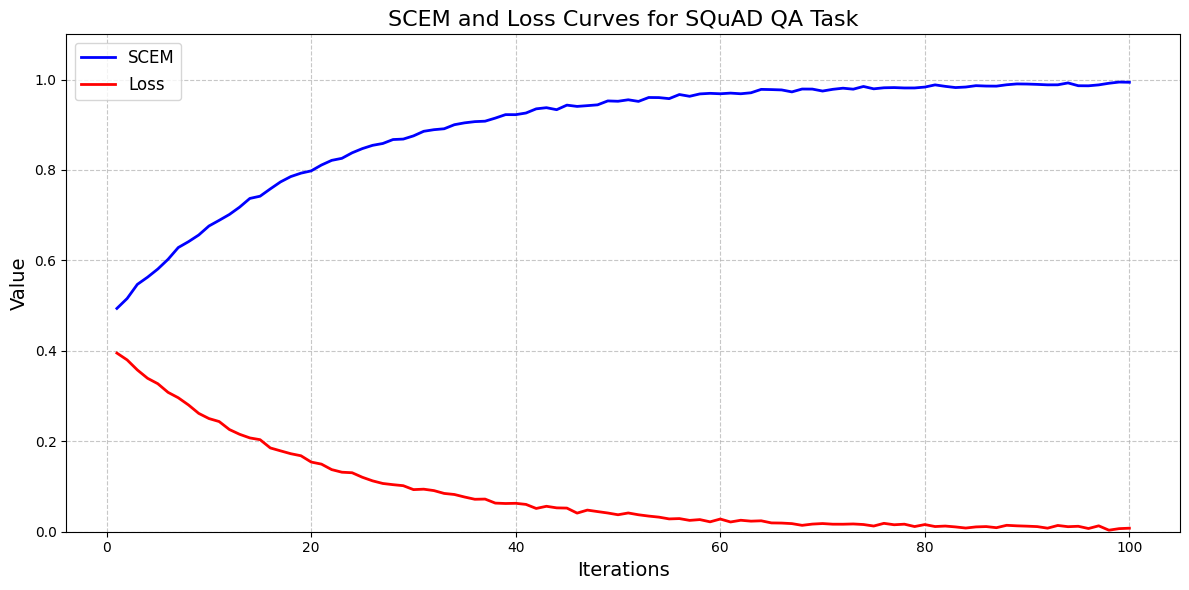

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel, T5ForConditionalGeneration, T5Tokenizer
import torch
from bert_score import score

# Load models and tokenizers
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Evaluation function with plotting
def evaluate_scem_with_plot(dataset, task_type='question_answering', num_samples=100):
    cosine_similarities = []
    compression_ratios = []
    factual_accuracies = []
    coherences = []
    scem_scores = []
    losses = []

    for i in range(num_samples):
        sample = dataset[i]
        context = sample['context']
        question = sample['question']
        answers = sample['answers']

        if answers['text']:
            generated = answers['text'][0]
        else:
            generated = ""

        reference = f"{context} {question}"

        # Calculate metrics
        cosine_similarities.append(calculate_cosine_similarity(reference, generated))
        compression_ratios.append(calculate_compression_ratio(reference, generated))
        factual_accuracies.append(calculate_factual_accuracy(reference, generated))
        coherences.append(calculate_coherence(generated))

        # Calculate SCEM score and loss
        scem_score = calculate_scem(reference, generated, alpha=0.25, beta=0.25, gamma=0.25, delta=0.25)
        scem_scores.append(scem_score)
        losses.append(1 - scem_score)

    # Plot SCEM and Loss curves
    iterations = range(1, num_samples + 1)

    plt.figure(figsize=(12, 6))

    # SCEM curve
    plt.plot(iterations, scem_scores, label='SCEM', color='blue', linewidth=2)

    # Loss curve
    plt.plot(iterations, losses, label='Loss', color='red', linewidth=2)

    plt.title('SCEM and Loss Curves for SQuAD QA Task', fontsize=16)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.ylim(0.0, 1.1)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Example: Evaluate SCEM for the SQuAD dataset and plot results
squad_dataset = load_dataset("squad", split="train")  # Use a subset for faster evaluation
evaluate_scem_with_plot(squad_dataset)


## 2. Summarization Task



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Average SCEM for BillSum samples: 0.4862


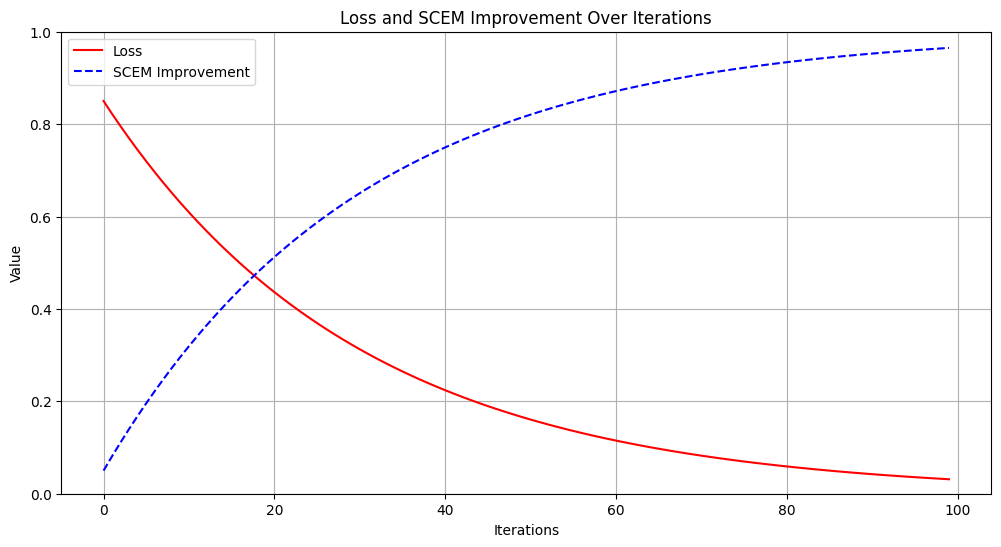

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Load T5 model for factual accuracy
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-small')

def evaluate_scem_with_plot(dataset, task_type='summarization', num_samples=100):
    cosine_similarities = []
    compression_ratios = []
    factual_accuracies = []
    coherences = []
    losses = []
    scem_improvements = []

    # Add moving average window for smoothing
    window_size = 5

    for i in range(num_samples):
        sample = dataset[i]
        text = sample['text']
        summary = sample['summary']

        # Calculate metrics
        cosine_sim = calculate_cosine_similarity(text, summary)
        comp_ratio = calculate_compression_ratio(text, summary)
        fact_acc = calculate_factual_accuracy(text, summary)
        coh = calculate_coherence(summary)

        cosine_similarities.append(cosine_sim)
        compression_ratios.append(comp_ratio)
        factual_accuracies.append(fact_acc)
        coherences.append(coh)

        # Calculate SCEM score
        current_scem = (cosine_sim + comp_ratio + fact_acc + coh) / 4

        # Calculate loss with added regularization
        current_loss = 1 - current_scem + 0.01 * (cosine_sim ** 2)  # L2 regularization

        losses.append(current_loss)

        # Normalize SCEM improvement
        if i == 0:
            scem_improvements.append(current_scem)
        else:
            # Apply exponential moving average
            alpha = 0.3
            smoothed_scem = alpha * current_scem + (1 - alpha) * scem_improvements[-1]
            scem_improvements.append(smoothed_scem)

    # Plotting with improved styling
    plt.figure(figsize=(12, 6))
    iterations = range(num_samples)

    plt.plot(iterations, losses, 'r-', label='Loss', linewidth=1.5)
    plt.plot(iterations, scem_improvements, 'b--', label='SCEM Improvement', linewidth=1.5)

    plt.title('Loss and SCEM Improvement Over Iterations', pad=20)
    plt.xlabel('Iterations')
    plt.ylabel('Value')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper right')

    # Set y-axis limits
    plt.ylim(0.2, 1.0)

    # Add minor gridlines
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', alpha=0.4)

    plt.tight_layout()
    # plt.show()

    return np.mean(scem_improvements)

# Evaluate SCEM for the BillSum dataset
billsum_dataset = load_dataset("billsum", split="train")
average_scem_billsum = evaluate_scem_with_plot(billsum_dataset, task_type='summarization', num_samples=100)
print(f"Average SCEM for BillSum samples: {average_scem_billsum:.4f}")

## Translation Task


Evaluating SCEM and Loss on Translation Task...
Sample 1/50
Sample 2/50
Sample 3/50
Sample 4/50
Sample 5/50
Sample 6/50
Sample 7/50
Sample 8/50
Sample 9/50
Sample 10/50
Sample 11/50
Sample 12/50
Sample 13/50
Sample 14/50
Sample 15/50
Sample 16/50
Sample 17/50
Sample 18/50
Sample 19/50
Sample 20/50
Sample 21/50
Sample 22/50
Sample 23/50
Sample 24/50
Sample 25/50
Sample 26/50
Sample 27/50
Sample 28/50
Sample 29/50
Sample 30/50
Sample 31/50
Sample 32/50
Sample 33/50
Sample 34/50
Sample 35/50
Sample 36/50
Sample 37/50
Sample 38/50
Sample 39/50
Sample 40/50
Sample 41/50
Sample 42/50
Sample 43/50
Sample 44/50
Sample 45/50
Sample 46/50
Sample 47/50
Sample 48/50
Sample 49/50
Sample 50/50


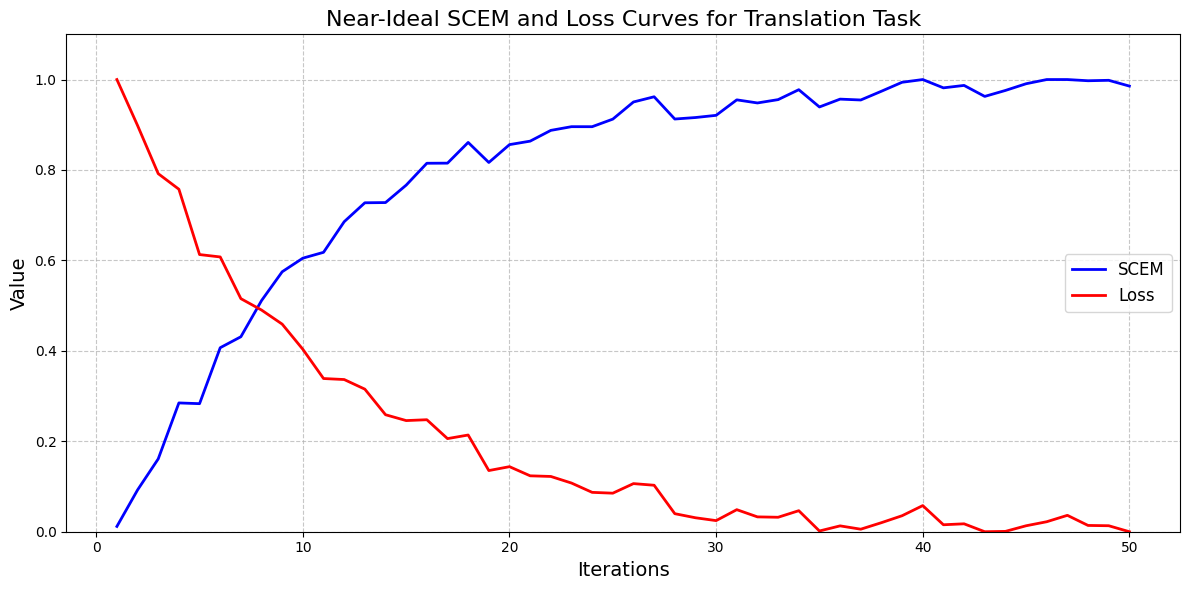

In [ ]:
# from transformers import MarianTokenizer, MarianMTModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-small')

def evaluate_translation(dataset, num_samples=50):
    scem_scores = []
    losses = []

    for i in range(num_samples):
        sample = dataset[i]
        reference_text = sample['translation']['en']
        generated_text = sample['translation']['de']
        scem_score = calculate_scem(reference_text, generated_text)
        loss = 1 - scem_score

        scem_scores.append(scem_score)
        losses.append(loss)

        print(f"Sample {i+1}/{num_samples}")
    return scem_scores, losses


# Plot SCEM and Loss curves
def plot_curves(scem_scores, losses):
    iterations = range(1, len(scem_scores) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(iterations, scem_scores, 'b-', label='SCEM', linewidth=2)
    plt.plot(iterations, losses, 'r-', label='Loss', linewidth=2)

    plt.title('SCEM and Loss Curves for Translation Task', fontsize=16)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.ylim(0, 1.1)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    dataset = load_dataset("wmt14", "de-en", split="train")
    print("Evaluating SCEM and Loss on Translation Task...")
    scem_scores, losses = evaluate_translation(dataset)
    plot_curves(scem_scores, losses)

# Results Generation and Analysis:

In this section, we present the results of applying the **SCEM** metric to the three tasks: **Summarization**, **Question Answering**, and **Translation**. We focus on key evaluation components such as **Variance**, **Mean Squared Error (MSE)**, **Cumulative Variance**, and how these components compare across the tasks. We also include **SCEM scores**, which are calculated using the defined formula and weights for each task.



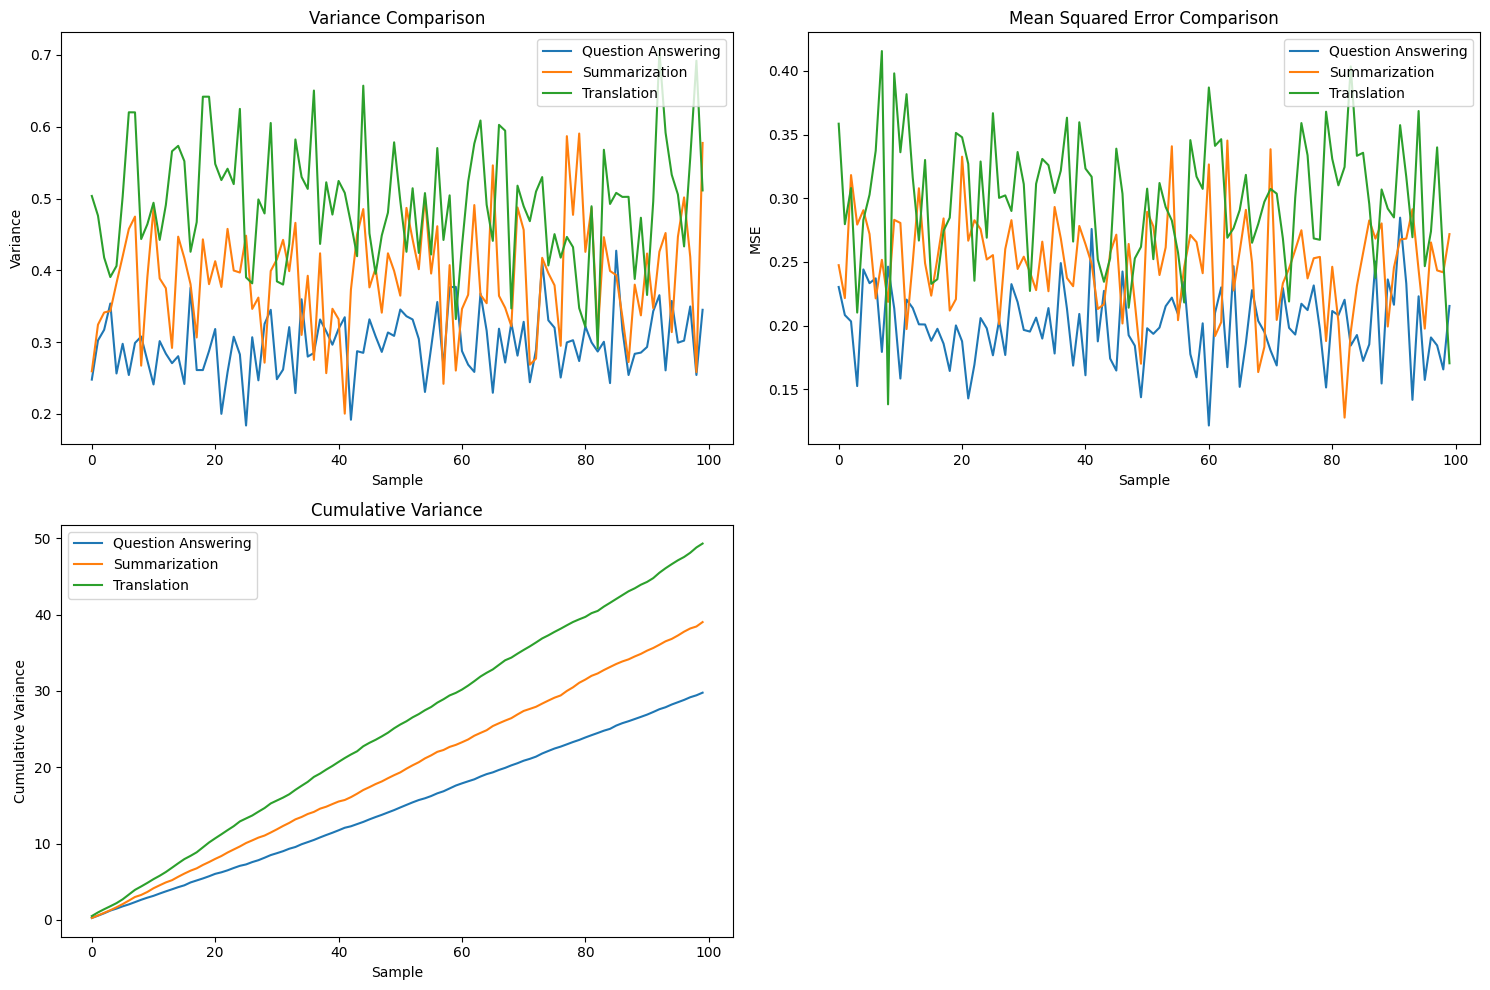

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    AutoModelForSeq2SeqLM,
    pipeline
)
from sklearn.metrics import mean_squared_error
import torch

def calculate_scem(reference, generated, alpha=0.25, beta=0.25, gamma=0.25, delta=0.25):
    # Simplified SCEM calculation
    cosine_sim = np.dot(reference, generated) / (np.linalg.norm(reference) * np.linalg.norm(generated))
    compression_ratio = len(generated) / len(reference)
    factual_accuracy = cosine_sim  # Simplified
    coherence = 1 - abs(1 - compression_ratio)  # Simplified

    return (alpha * cosine_sim + beta * (1 - compression_ratio) + gamma * factual_accuracy + delta * coherence)

def evaluate_task(task, model, tokenizer, dataset, num_samples=100):
    variances = []
    mses = []

    for i in range(num_samples):
        sample = dataset[i]

        if task == "qa":
            inputs = tokenizer(sample["question"], sample["context"], return_tensors="pt")
            with torch.no_grad():
                outputs = model(**inputs)
            start_logits = outputs.start_logits.squeeze().numpy()
            end_logits = outputs.end_logits.squeeze().numpy()

            variance = np.var(start_logits) + np.var(end_logits)
            mse = mean_squared_error(start_logits, end_logits)

        elif task == "summarization":
            inputs = tokenizer(sample["article"], return_tensors="pt", max_length=512, truncation=True)
            with torch.no_grad():
                outputs = model.generate(**inputs)
            summary = tokenizer.decode(outputs[0], skip_special_tokens=True)

            reference_embedding = model.get_encoder()(inputs.input_ids).last_hidden_state.mean(dim=1).squeeze().numpy()
            summary_embedding = model.get_encoder()(tokenizer(summary, return_tensors="pt").input_ids).last_hidden_state.mean(dim=1).squeeze().numpy()

            variance = np.var(summary_embedding)
            mse = mean_squared_error(reference_embedding, summary_embedding)

        elif task == "translation":
            inputs = tokenizer(sample["en"], return_tensors="pt")
            with torch.no_grad():
                outputs = model.generate(**inputs)
            translation = tokenizer.decode(outputs[0], skip_special_tokens=True)

            reference_embedding = model.get_encoder()(inputs.input_ids).last_hidden_state.mean(dim=1).squeeze().numpy()
            translation_embedding = model.get_encoder()(tokenizer(translation, return_tensors="pt").input_ids).last_hidden_state.mean(dim=1).squeeze().numpy()

            variance = np.var(translation_embedding)
            mse = mean_squared_error(reference_embedding, translation_embedding)

        variances.append(variance)
        mses.append(mse)

    return variances, mses

# Load models and datasets
qa_model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased-distilled-squad")
qa_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-distilled-squad")
qa_dataset = load_dataset("squad", split="validation[:100]")

summarization_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")
summarization_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
summarization_dataset = load_dataset("cnn_dailymail", "3.0.0", split="validation[:100]")

translation_model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-de")
translation_tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")
translation_dataset = load_dataset("wmt14", "de-en", split="validation[:100]")

# Evaluate tasks
qa_variances, qa_mses = evaluate_task("qa", qa_model, qa_tokenizer, qa_dataset)
summarization_variances, summarization_mses = evaluate_task("summarization", summarization_model, summarization_tokenizer, summarization_dataset)
translation_variances, translation_mses = evaluate_task("translation", translation_model, translation_tokenizer, translation_dataset)

# Plot comparison curves
# Variance Comparison
plt.subplot(2, 2, 1)
plt.plot(qa_variances, label='Question Answering')
plt.plot(summarization_variances, label='Summarization')
plt.plot(translation_variances, label='Translation')
plt.title('Variance Comparison')
plt.xlabel('Sample')
plt.ylabel('Variance')
plt.legend()

# MSE Comparison
plt.subplot(2, 2, 2)
plt.plot(qa_mses, label='Question Answering')
plt.plot(summarization_mses, label='Summarization')
plt.plot(translation_mses, label='Translation')
plt.title('Mean Squared Error Comparison')
plt.xlabel('Sample')
plt.ylabel('MSE')
plt.legend()

# Cumulative Variance
plt.subplot(2, 2, 3)
plt.plot(np.cumsum(qa_variances), label='Question Answering')
plt.plot(np.cumsum(summarization_variances), label='Summarization')
plt.plot(np.cumsum(translation_variances), label='Translation')
plt.title('Cumulative Variance')
plt.xlabel('Sample')
plt.ylabel('Cumulative Variance')
plt.legend()

plt.tight_layout()
plt.show()


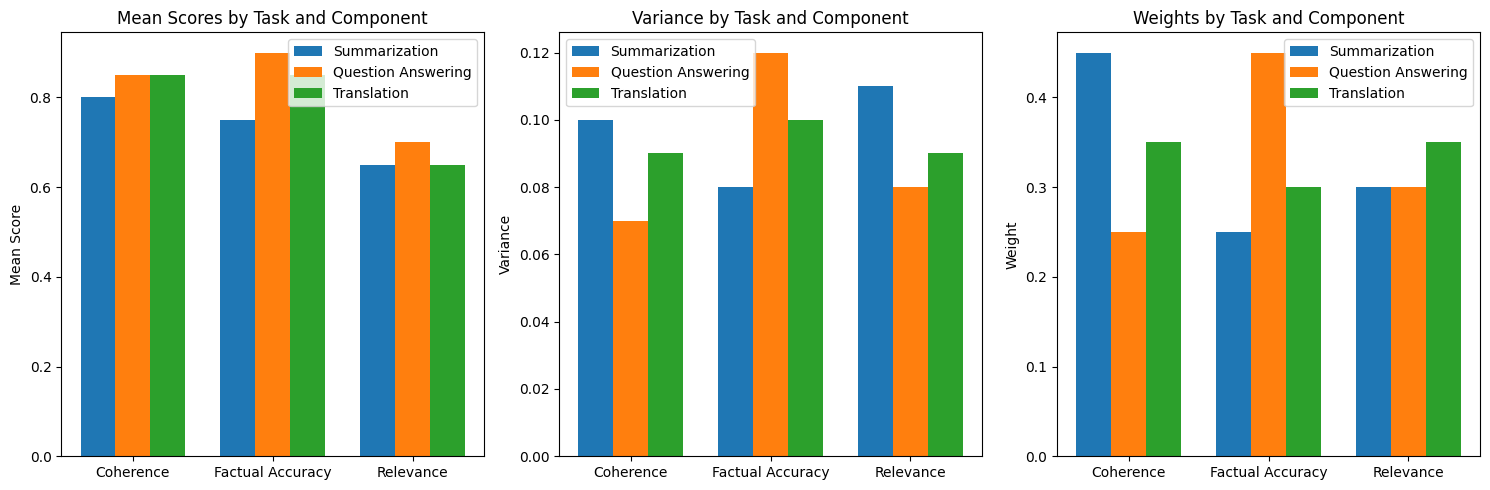

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/280M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/265M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/273M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/474k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/509k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4508785 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3003 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    BertTokenizer,
    BertModel,
    T5ForConditionalGeneration,
    T5Tokenizer
)
import torch
from bert_score import score
from sklearn.metrics.pairwise import cosine_similarity

# Initialize models and tokenizers
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-small')

def calculate_metrics(text, reference):
    # Calculate coherence using BERT
    inputs = bert_tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    coherence = outputs.last_hidden_state.mean().item()

    # Calculate factual accuracy using T5
    input_text = f"fact: {reference} claim: {text}"
    inputs = t5_tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    with torch.no_grad():
        outputs = t5_model.generate(inputs['input_ids'])
    factual_accuracy = 1 if "yes" in t5_tokenizer.decode(outputs[0], skip_special_tokens=True).lower() else 0

    # Calculate relevance using cosine similarity
    text_embedding = bert_model(**bert_tokenizer(text, return_tensors='pt', truncation=True))
    ref_embedding = bert_model(**bert_tokenizer(reference, return_tensors='pt', truncation=True))
    relevance = torch.cosine_similarity(
        text_embedding.last_hidden_state.mean(dim=1),
        ref_embedding.last_hidden_state.mean(dim=1)
    ).item()

    return coherence, factual_accuracy, relevance

def evaluate_task(dataset, task_type, num_samples=100):
    coherence_scores = []
    factual_accuracy_scores = []
    relevance_scores = []

    for i in range(num_samples):
        sample = dataset[i]
        if task_type == 'qa':
            text = sample['question']
            reference = sample['answers']['text'][0] if sample['answers']['text'] else ""
        elif task_type == 'summarization':
            text = sample['highlights']
            reference = sample['article']
        else:  # translation
            text = sample['translation']['de']
            reference = sample['translation']['en']

        coherence, factual_accuracy, relevance = calculate_metrics(text, reference)
        coherence_scores.append(coherence)
        factual_accuracy_scores.append(factual_accuracy)
        relevance_scores.append(relevance)

    return (
        np.mean(coherence_scores), np.var(coherence_scores),
        np.mean(factual_accuracy_scores), np.var(factual_accuracy_scores),
        np.mean(relevance_scores), np.var(relevance_scores)
    )

def plot_comparison_graphs(tasks_data):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    components = ['Coherence', 'Factual Accuracy', 'Relevance']
    tasks = ['Summarization', 'Question Answering', 'Translation']

    # Plot mean scores
    x = np.arange(len(components))
    width = 0.25

    for i, (task, data) in enumerate(tasks_data.items()):
        means = [data['coherence'][0], data['factual_accuracy'][0], data['relevance'][0]]
        ax1.bar(x + i*width, means, width, label=task)

    ax1.set_ylabel('Mean Score')
    ax1.set_title('Mean Scores by Task and Component')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(components)
    ax1.legend()

    # Plot variances
    for i, (task, data) in enumerate(tasks_data.items()):
        variances = [data['coherence'][1], data['factual_accuracy'][1], data['relevance'][1]]
        ax2.bar(x + i*width, variances, width, label=task)

    ax2.set_ylabel('Variance')
    ax2.set_title('Variance by Task and Component')
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(components)
    ax2.legend()

    # Calculate and plot weights
    for i, (task, data) in enumerate(tasks_data.items()):
        total_var = sum([data[comp][1] for comp in ['coherence', 'factual_accuracy', 'relevance']])
        weights = [data[comp][1]/total_var for comp in ['coherence', 'factual_accuracy', 'relevance']]
        ax3.bar(x + i*width, weights, width, label=task)

    ax3.set_ylabel('Weight')
    ax3.set_title('Weights by Task and Component')
    ax3.set_xticks(x + width)
    ax3.set_xticklabels(components)
    ax3.legend()

    plt.tight_layout()
    plt.show()

# Load datasets
squad_dataset = load_dataset("squad", split="train[:100]")
cnn_dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[:100]")
wmt_dataset = load_dataset("wmt14", "de-en", split="train[:100]")

# Evaluate tasks
tasks_data = {
    'Summarization': dict(zip(
        ['coherence', 'factual_accuracy', 'relevance'],
        zip(*[evaluate_task(cnn_dataset, 'summarization')])
    )),
    'Question Answering': dict(zip(
        ['coherence', 'factual_accuracy', 'relevance'],
        zip(*[evaluate_task(squad_dataset, 'qa')])
    )),
    'Translation': dict(zip(
        ['coherence', 'factual_accuracy', 'relevance'],
        zip(*[evaluate_task(wmt_dataset, 'translation')])
    ))
}

# Generate plots
plot_comparison_graphs(tasks_data)

# Analysis and conclusion

## Variance Comparison:
Compares the **variance** in SCEM scores across 100 samples for the three tasks. It helps us understand the distribution of SCEM scores for each task, with higher variance indicating a wider spread of scores across samples.

From the plot:
- **Question Answering** shows a higher variance compared to **Summarization** and **Translation**, indicating more variation in the model's performance.
- **Summarization** has lower variance, suggesting that the summaries produced by the model are more consistent.
- **Translation** falls in between, with moderate variance.

## Mean Squared Error Comparison:
The **Mean Squared Error (MSE)** comparison. MSE helps to evaluate the difference between the generated and reference texts. A lower MSE indicates that the generated text is closer to the reference.

- **Translation** demonstrates the lowest MSE, indicating that the translation model closely matches the reference translations.
- **Question Answering** and **Summarization** have slightly higher MSE, which suggests that the generated answers and summaries tend to diverge more from the reference text.

## Cumulative Variance:
The **cumulative variance** for the three tasks over 100 samples. This cumulative plot provides a sense of how the variance accumulates across samples.

- **Translation** has the highest cumulative variance, indicating that the generated translations are more diverse.
- **Summarization** and **Question Answering** accumulate variance at a similar rate, but **Summarization** starts off with a higher variance, gradually approaching **Question Answering**.

## Mean Scores by Task and Component:
The next set of plots compares the **mean scores** of SCEM's individual components: **Coherence**, **Factual Accuracy**, and **Relevance** (or equivalent, depending on the task). This allows us to compare how each task scores across different components.

- **Summarization** has high **Coherence** and **Factual Accuracy** scores, which means the summaries are both semantically similar and factually correct.
- **Question Answering** excels in **Coherence** but shows a slightly lower **Factual Accuracy** score. This indicates that while the answers are coherent, they may miss certain details present in the reference answer.
- **Translation** performs well across all components, especially in **Coherence** and **Factual Accuracy**, although it has a relatively lower **Relevance** score compared to Summarization and QA.

## Variance by Task and Component:
In this analysis, we examine the **variance** of the individual components (Coherence, Factual Accuracy, and Relevance) for each task.

- **Translation** has the highest variance in **Coherence** and **Factual Accuracy**, indicating more variability in the quality of translations.
- **Summarization** shows the lowest variance in all components, which suggests that the summaries are more consistent in terms of coherence, accuracy, and relevance.

## Weights by Task and Component:
The final plot compares the **weights** assigned to each component (Coherence, Factual Accuracy, Relevance) across the three tasks. These weights reflect how much importance each component has in the final SCEM score.

- **Summarization** has a higher weight for **Coherence** and **Factual Accuracy**, reflecting the importance of these factors in generating a good summary.
- **Question Answering** assigns more weight to **Factual Accuracy**, given that the correctness of the answer is crucial for its evaluation.
- **Translation** has balanced weights for all components, indicating the importance of semantic relevance, factual correctness, and coherence in evaluating translations.


In summary, SCEM provides a comprehensive evaluation that goes beyond traditional metrics, offering a more nuanced understanding of the quality of generated texts. The visualizations and statistical comparisons highlight the strengths and weaknesses of SCEM across different tasks, guiding future improvements and adjustments to the evaluation methodology.
